# Chap 11 - Ex3: classify customer into different groups based on data ageinc_g.csv (Age, Income, Gender)
## Use KMeansClustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)

In [2]:
shopping = pd.read_csv('Data/shopping_data.csv', index_col = 'CustomerID')
shopping

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [3]:
shopping.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [4]:
#Use Regular Expression to modify columns' names
shopping.columns = shopping.columns.str.replace('\(|\)', '', regex = True).str.replace('-| ', '_', regex=True)
shopping

<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_783391/1153038814.py:2: SyntaxWarning: invalid escape sequence '\('
  shopping.columns = shopping.columns.str.replace('\(|\)', '', regex = True).str.replace('-| ', '_', regex=True)


,Genre,Age,Annual_Income_k$,Spending_Score_1_100
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [5]:
shopping.describe()

,Age,Annual_Income_k$,Spending_Score_1_100
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## <span style = 'color:yellow'> Check normal distribution and outliers of Age, Annual_Income and Spending_Score

Normality test of Age: ShapiroResult(statistic=0.9516182290435912, pvalue=2.710855723091019e-06)
Normality test of Annual_Income: ShapiroResult(statistic=0.9783897545646609, pvalue=0.0035365109581996213)
Normality test of Spending_Score: ShapiroResult(statistic=0.9694606767011337, pvalue=0.00024229713933301153)



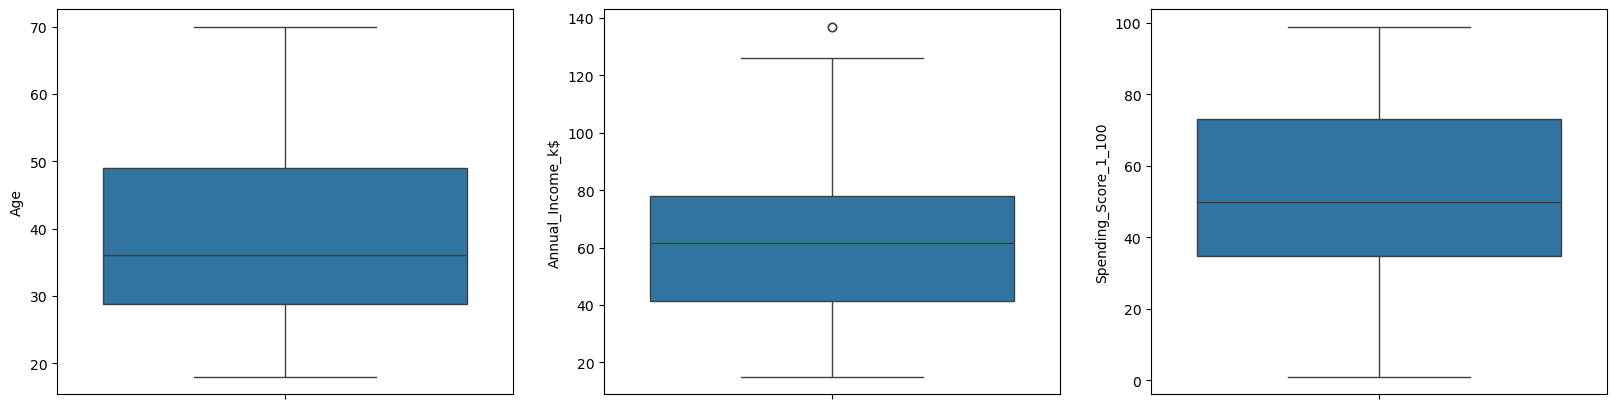


Age, Annual_Income and Spending_Score are not normally distributed, but do not have outliers => can use MinMaxScaler


In [6]:
from scipy.stats import shapiro
print(f'Normality test of Age: {shapiro(shopping['Age'])}')
print(f'Normality test of Annual_Income: {shapiro(shopping['Annual_Income_k$'])}')
print(f'Normality test of Spending_Score: {shapiro(shopping['Spending_Score_1_100'])}')

print()

plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
sbn.boxplot(data = shopping, y = 'Age')
plt.subplot(1,3,2)
sbn.boxplot(data = shopping, y = 'Annual_Income_k$')
plt.subplot(1,3,3)
sbn.boxplot(data = shopping, y = 'Spending_Score_1_100')
plt.show()

print('\nAge, Annual_Income and Spending_Score are not normally distributed, but do not have outliers => can use MinMaxScaler')

## <span style = 'color:yellow'> Find optimal K using Elbow Method and Silhoutte Score

Silhouette score for k = 2: 0.5194624832665107
Silhouette score for k = 3: 0.45632990097013176
Silhouette score for k = 4: 0.36156051651908966
Silhouette score for k = 5: 0.37063226192201243
Silhouette score for k = 6: 0.3621344305239934
Silhouette score for k = 7: 0.36858404957000745
Silhouette score for k = 8: 0.391412246231337
Silhouette score for k = 9: 0.41860213948684516
Silhouette score for k = 10: 0.41276913589749
Silhouette score for k = 11: 0.397523447137084
Silhouette score for k = 12: 0.4132081752886714
Silhouette score for k = 13: 0.40303902864025837
Silhouette score for k = 14: 0.39422206601655146
Silhouette score for k = 15: 0.38544206994863034


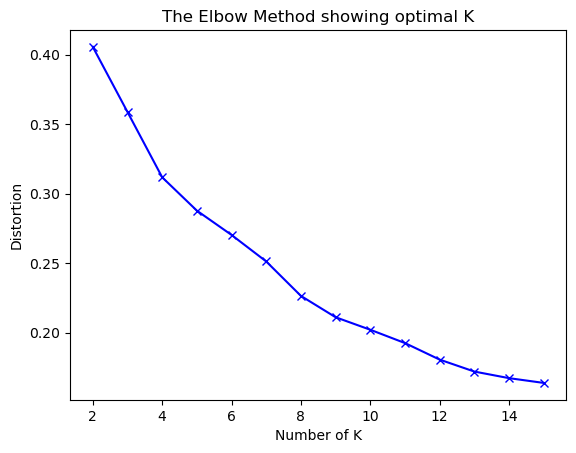


Choose K = 4


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
import math

distortions = []
k_nums = range(2,16)

data = shopping.copy()

for k in k_nums:
    kmeans_pipe = Pipeline([
        ('OneHotEncoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), ['Genre']), remainder='passthrough')),
        ('MinMaxScaler', MinMaxScaler()),
        ('KMeansModel', KMeans(n_clusters = k, random_state = 2))
    ])
    kmeans_pipe.fit(data)
    data_scaled = (
        pd.DataFrame(kmeans_pipe[:-1].transform(data)) #Transform original data with onehotencoder and MinMaxScaler
        .pipe(lambda df: df.set_axis(kmeans_pipe.named_steps['OneHotEncoder'].get_feature_names_out(), axis =1))
    )
     
    centroids = kmeans_pipe.named_steps['KMeansModel'].cluster_centers_
    sum_var = sum(np.min(cdist(data_scaled, centroids, 'euclidean'), axis = 1)) / data.shape[0]
    distortions.append(sum_var)
    labels = kmeans_pipe.named_steps['KMeansModel'].labels_
    print(f'Silhouette score for k = {k}: {silhouette_score(data_scaled, labels)}')

plt.plot(k_nums, distortions, 'bx-')
plt.xlabel('Number of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing optimal K')
plt.show()

print('\nChoose K = 4')

## <span style = 'color:yellow'> Build official KMeansClustering with K = 4

In [8]:
kmeans_pipe = Pipeline([
    ('OneHotEncoder', make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), ['Genre']), remainder='passthrough')),
    ('MinMaxScaler', MinMaxScaler()),
    ('KMeansModel', KMeans(n_clusters = 4, random_state = 2))
])

kmeans_pipe.fit(shopping)

centroids = kmeans_pipe.named_steps['KMeansModel'].cluster_centers_
centroids = kmeans_pipe.named_steps['MinMaxScaler'].inverse_transform(centroids)
labels = kmeans_pipe.named_steps['KMeansModel'].labels_

print('Coordinate of all centroids:\n', centroids)
print()

shopping_group = shopping.copy()
shopping_group['Group'] = labels
print(shopping_group)

Coordinate of all centroids:
 [[-0.         28.43859649 59.66666667 67.68421053]
 [ 1.         52.73809524 62.21428571 30.64285714]
 [ 1.         28.         62.23913043 64.82608696]
 [-0.         48.10909091 58.81818182 34.78181818]]

             Genre  Age  Annual_Income_k$  Spending_Score_1_100  Group
CustomerID                                                            
1             Male   19                15                    39      2
2             Male   21                15                    81      2
3           Female   20                16                     6      3
4           Female   23                16                    77      0
5           Female   31                17                    40      0
...            ...  ...               ...                   ...    ...
196         Female   35               120                    79      0
197         Female   45               126                    28      3
198           Male   32               126             

# <span style = 'color:yellow'> Report clustering results

In [75]:
# Method 1

data_group = shopping_group.copy()

for group in data_group['Group'].unique():
    print(f'\n=============== Cluster group {group} =========================\n')
    data = data_group[data_group['Group'] == group]
    print(f'n_observations: {data.shape[0]}\n')
    for col_name in data.columns[:-1]:
        if col_name in ['Genre']:
            print(f'{data[col_name].value_counts().to_frame().reset_index()}')
            print()
        else:
            print(f'{col_name}: {np.min(data[col_name])} ~ {np.median(data[col_name])} ~ {np.max(data[col_name])}')
            print()


=============== Cluster group 2 =========================

n_observations: 46

  Genre  count
0  Male     46

Age: 18 ~ 28.0 ~ 40

Annual_Income_k$: 15 ~ 65.5 ~ 137

Spending_Score_1_100: 5 ~ 68.5 ~ 97


=============== Cluster group 3 =========================

n_observations: 55

    Genre  count
0  Female     55

Age: 20 ~ 49.0 ~ 68

Annual_Income_k$: 16 ~ 57.0 ~ 126

Spending_Score_1_100: 5 ~ 39.0 ~ 59


=============== Cluster group 0 =========================

n_observations: 57

    Genre  count
0  Female     57

Age: 18 ~ 30.0 ~ 40

Annual_Income_k$: 16 ~ 62.0 ~ 120

Spending_Score_1_100: 29 ~ 73.0 ~ 99


=============== Cluster group 1 =========================

n_observations: 42

  Genre  count
0  Male     42

Age: 32 ~ 52.5 ~ 70

Annual_Income_k$: 19 ~ 62.0 ~ 137

Spending_Score_1_100: 1 ~ 35.5 ~ 60



Number of numeric fields: 3

All numeric fields: ['Age', 'Annual_Income_k$', 'Spending_Score_1_100']



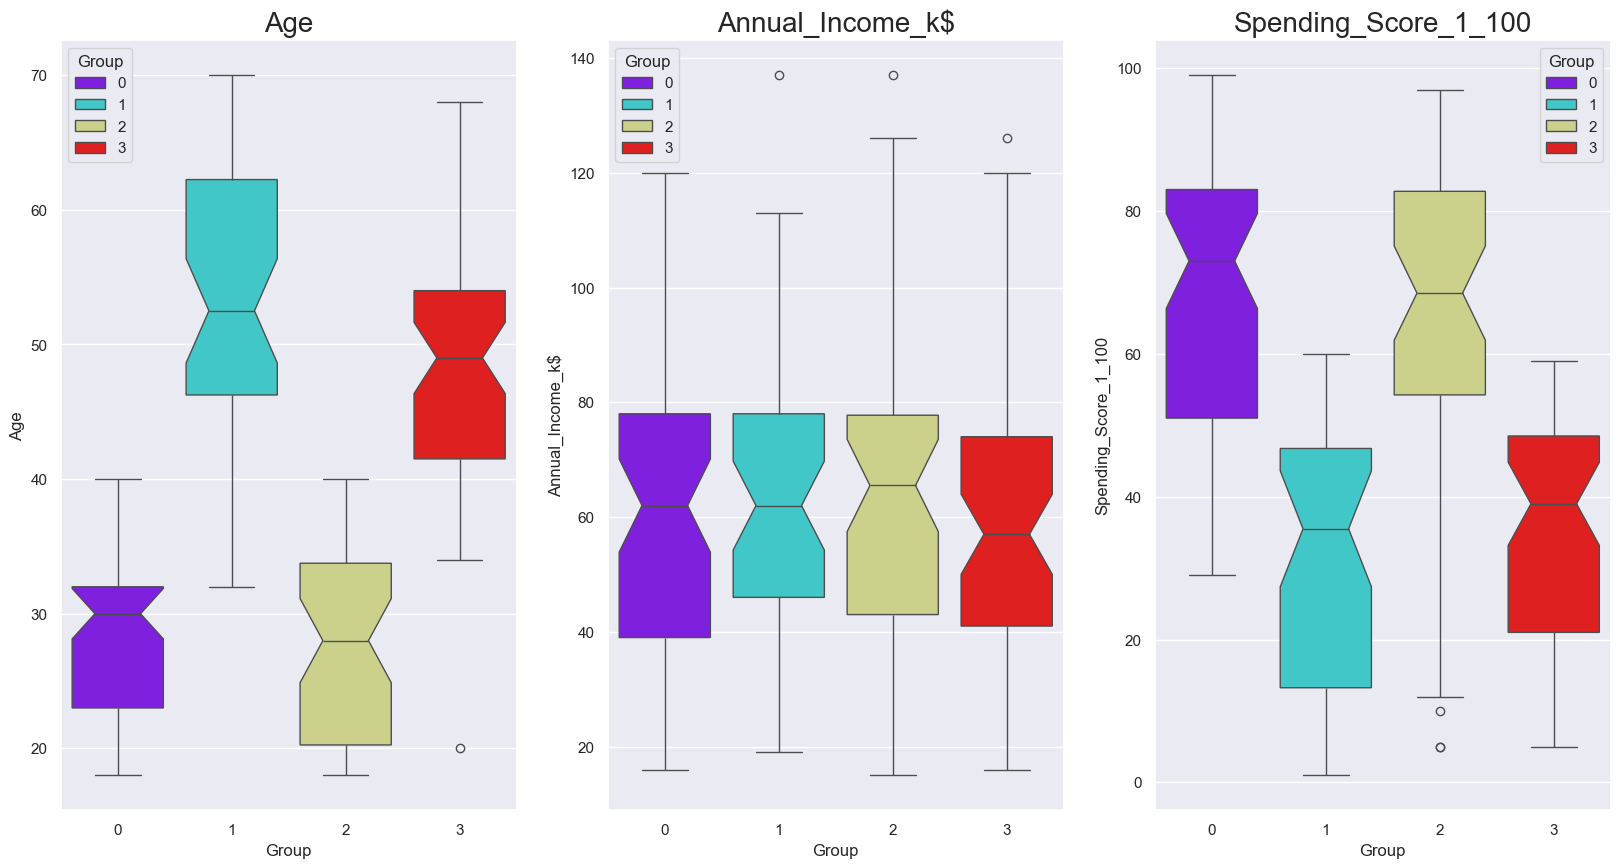


-----------------------------------------------------------------------------------------------------------------------------

Number of categorical fields: 1

All categorical fields: ['Genre']



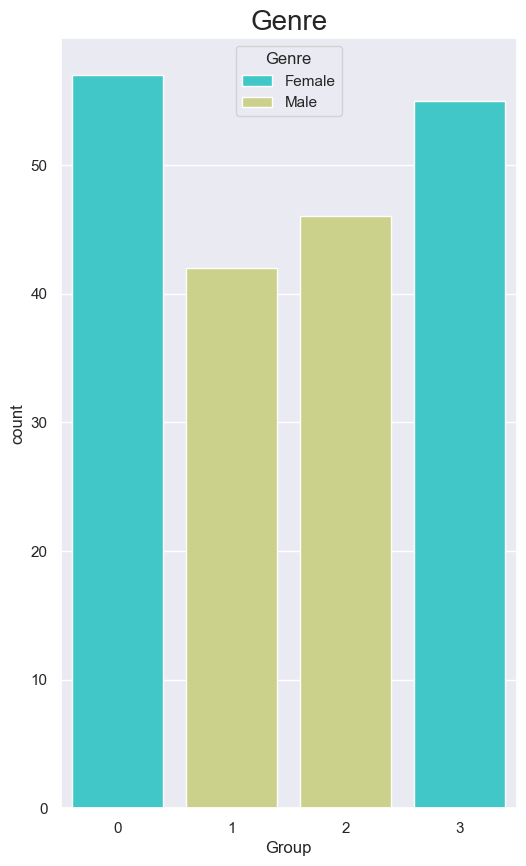

In [77]:
# Method 3: visualizing

data_group = shopping_group.copy()

numeric_cols = ['Age', 'Annual_Income_k$', 'Spending_Score_1_100']
categ_cols = ['Genre']

##### Function building ##############

def boxplot_numeric(df, numeric_cols, figsize=(20, 10), groups = None):
    col = 3
    if (len(numeric_cols) % 3) == 0:
        row = len(numeric_cols) // 3
    else:
        row = (len(numeric_cols) // 3) + 1
    '''
    numeric_cols: list các tên cột biến định lượng
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of numeric fields: {len(numeric_cols)}')
    print()
    print(f'All numeric fields: {numeric_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.boxplot(data = df, x = groups, y = numeric_cols[i-1], notch = True, hue = groups, palette = 'rainbow')
        plt.title(numeric_cols[i-1], size = 20)
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break
    plt.show()


def countplot_categ(df, categ_cols, figsize=(20, 10), groups = None):
    col = 3
    if (len(categ_cols) % 3) == 0:
        row = len(categ_cols) // 3
    else:
        row = (len(categ_cols) // 3) + 1
    '''
    categ_cols: list các tên cột biến định tính
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    groups: tên cột chứa biến phân nhóm như 'Group' hoặc 'Class' hoặc 'Label'
    '''
    print(f'Number of categorical fields: {len(categ_cols)}')
    print()
    print(f'All categorical fields: {categ_cols}')
    print()
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    for i in range(1, len(categ_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        sbn.countplot(data = df, x = groups, hue = categ_cols[i-1], palette = 'rainbow')
        plt.title(categ_cols[i-1], size = 20)
      except:
        print('Error {}'.format(categ_cols[i-1]))
        break
    plt.show()

## Draw
sbn.set_theme(style ='darkgrid')
boxplot_numeric(data_group, numeric_cols, groups = data_group.iloc[:,-1])
print('\n-----------------------------------------------------------------------------------------------------------------------------\n')
countplot_categ(data_group, categ_cols, groups = data_group.iloc[:,-1])